<a href="https://colab.research.google.com/github/Amarantine-xiv/Amas-FF14-Combat-Sim/blob/main/Logs_Simulator_Dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instructions for use: From the Github, click "Open in Colab". You may need to log into Google's Colab, a Jupyter Python notebook service with free access. Hit File > Save a Copy in Drive (you only have to do this once).

DO NOT USE THIS NOTEBOOK (FOR NOW) UNLESS YOU ARE A DEV, MAINLY BECAUSE THERE ARE SOME (TEMPORARY?) HACKS HERE YOU HAVE TO BE CAREFUL OF, AND IT'LL BITE YOU IF YOU DON'T KNOW WHAT THEY ARE.

To get fflogs data, you will need `FFLOGS_CLIENT_ID` and `FFLOGS_CLIENT_SECRET` set as secrets. These values can be obtained here: https://www.fflogs.com/api/clients/

To set secrets, click the Key icon to the left.



/content
fatal: destination path 'Amas-FF14-Combat-Sim' already exists and is not an empty directory.
/content/Amas-FF14-Combat-Sim
Already up to date.
Time taken: 2.508074998855591
Results: 
Average DPS: 13644.14
Percentile 25: 13346.63
Percentile 50: 13631.91
Percentile 75: 13926.29
Percentile 95: 14355.20
Percentile 99: 14653.17

Average Damage: 477544.90
Percentile 25: 467132.00
Percentile 50: 477117.00
Percentile 75: 487420.00
Percentile 95: 502432.05
Percentile 99: 512861.00

---Expected max damage over N runs---
1 Runs: 13648.92
5 Runs: 14136.95
10 Runs: 14305.61
20 Runs: 14452.98
50 Runs: 14613.19
100 Runs: 14731.27


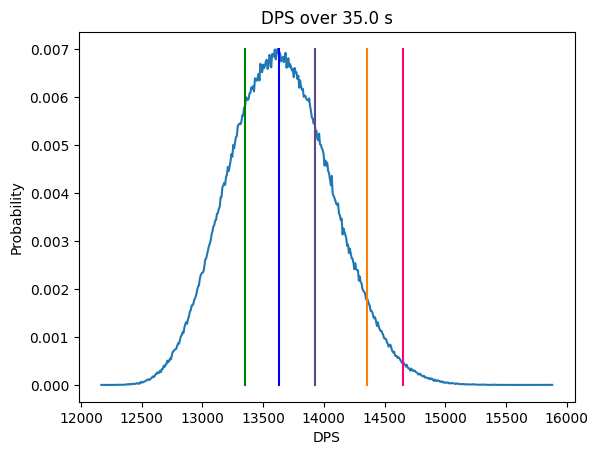

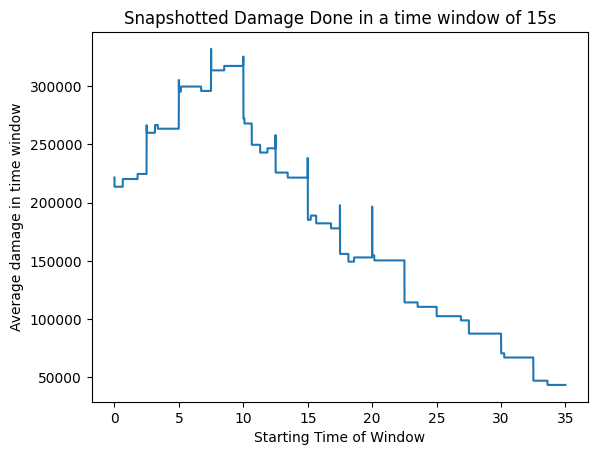

---Times (in ms) when skills get used:---
       0:               Tomahawk
     650:              Infuriate
     800:          Arcane Circle
    2500:            Heavy Swing
    5000:                   Maim
    5650:       Grade 8 Tincture
    6280:               Embolden
    6300:        Chain Stratagem
    7100:          Battle Litany
    7500:            Storm's Eye
    8150:          Inner Release
   10000:            Inner Chaos
   10650:               Upheaval
   11300:              Onslaught
   12500:            Primal Rend
   15000:            Inner Chaos
   15650:              Onslaught
   17500:            Fell Cleave
   18150:              Onslaught
   20000:            Fell Cleave
   22500:            Fell Cleave
   25000:            Heavy Swing
   27500:                   Maim
   30000:           Storm's Path
   32500:            Fell Cleave
   35000:            Inner Chaos


---Times (in ms) when damage lands:---
time:      0.0, name:                   Auto, expected_dama

In [17]:
#@title Imports and Setup
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dataclasses
import functools
import requests
import pprint
import re
import copy
from collections import namedtuple
from google.colab import userdata

GITHUB_PTA = userdata.get('GITHUB_PTA')
if not GITHUB_PTA:
  raise Exception(f"Please set Github Public Access Token (GITHUB_PTA) secret.")

# Ensure FFLOGS values are set when using this. Please set
# as secrets and do not use them in plaintext.
if not (userdata.get("FFLOGS_CLIENT_ID") or userdata.get("FFLOGS_CLIENT_SECRET")):
  raise Exception(f"Please set FFLOGs tokens to access logs. https://www.fflogs.com/api/clients/")

# TODO: move a lot of the implementation into python files on git
# So it can also just be added onto drive

%cd /content
!git clone https://"$GITHUB_PTA"@github.com/Amarantine-xiv/Amas-FF14-Combat-Sim
%cd /content/Amas-FF14-Combat-Sim
!git pull

%run '/content/Amas-FF14-Combat-Sim/CoreSimulator.ipynb'

In [18]:
#@title Logging setup

pd.options.mode.copy_on_write = True

from typing import *

import logging
logger = logging.getLogger()
# Modify this value to set logging level.
logging_level = logging.INFO
logger.setLevel(logging_level)
logger.log(logging_level, f"Set logging level to {logging_level}")

LOG = logging.getLogger("logs_simulator")

# Pip req imports
!pip install coreapi==2.3.3 python-graphql-client==0.4.3
import coreapi
import python_graphql_client


INFO:root:Set logging level to 20


In [19]:
#@title Custom FFLOGs constants
"""Defines and documents all custom columns in the data."""

# Not custom, but used a lot so recorded
ABILITY_ID = "abilityGameID"
TYPE = "type"
CAST = "cast"
DAMAGE = "damage"
APPLY_BUFF = "applybuff"
APPLY_DEBUFF = "applydebuff"
REFRESH_BUFF = "refreshbuff"
REMOVE_BUFF = "removebuff"
REMOVE_DEBUFF = "removedebuff"
PREPARE = "calculateddamage"

# Human readable name for abilities
ABILITY_NAME = "ability_name"

# Human readable source name for actors
SOURCE_NAME = "source_name"
SOURCE_TYPE = "source_type"
SOURCE_SUBTYPE = "source_subtype"
SOURCE_PET_ACTOR = "source_pet_actor"
SOURCE_ID = "sourceID"

# Human readable target name for actors
TARGET_NAME = "target_name"
TARGET_TYPE = "target_type"
TARGET_SUBTYPE = "target_subtype"
TARGET_PET_ACTOR = "target_pet_actor"
TARGET_ID = "targetID"

# Fight time, based on lb update tick to reset gauge
FIGHT_TIME = "fight_time"

# Bonus percent, estimate the value of combos
# 1 - basePotency/bonusPotency = bonusPercent
BONUS_PERCENT = "bonusPercent"
AMOUNT = "amount"
LOG_DAMAGE = "unmitigatedAmount"  # amount column is affected by overkill
LOG_HIT_TYPE = "hitType"
LOG_DHIT = "directHit"
LOG_MULTIPLIER = "multiplier"

# Replaced names
CRIT = "crit"
DHIT = "direct_hit"

# Special name added in for an assumed prepull apply
ESTIMATED_APPLY_BUFF = "estimatedapplybuff"

# Special name for "correct" card
CARD_MATCHES_JOB = "card_matches_job"

# Mappings (target_subtype)
JOB = "Job"

# Breaking melee vs ranged in seperate mapping
TARGET_SUBTYPE_TO_JOB_MELEE = {
    "DarkKnight": "DRK",
    "Gunbreaker": "GNB",
    "Paladin": "PLD",
    "Warrior": "WAR",
    "Ninja": "NIN",
    "Samurai": "SAM",
    "Reaper": "RPR",
    "Monk": "MNK",
    "Dragoon": "DRG",
}

TARGET_SUBTYPE_TO_JOB_RANGED = {
    "Dancer": "DNC",
    "Bard": "BRD",
    "Machinist": "MCH",
    "RedMage": "RDM",
    "BlackMage": "BLM",
    "Summoner": "SMN",
    "Astrologian": "AST",
    "Scholar": "SCH",
    "Sage": "SGE",
    "WhiteMage": "WHM",
}

TARGET_SUBTYPE_TO_JOB = {
    **TARGET_SUBTYPE_TO_JOB_MELEE,
    **TARGET_SUBTYPE_TO_JOB_RANGED,
}


In [20]:
#@title FFLOGS Api

def parse_fflogs_url(url):
  URL_REGEXP = "https://www.fflogs.com/reports/(\w+)\#fight=(\d+)"
  tmp =re.search(URL_REGEXP, url)
  return tmp[1], int(tmp[2])

def get_auth_token() -> str:
    """Fetches an auth token via https://www.fflogs.com/oauth/token.

    See https://www.fflogs.com/api/docs/

    And https://www.fflogs.com/v2-api-docs/ff/report.doc.html

    Requires FFLOGS_CLIENT_ID and FFLOGS_CLIENT_SECRET set as variables.
    These can be obtained here: https://www.fflogs.com/api/clients/

    Please keep these private to yourself and do not upload them to
    github or share them.

    :returns: Auth token for FFLogs APIv2
    """
    LOG.debug(f"Fetching fflogs auth token")
    x = requests.post(
        url="https://www.fflogs.com/oauth/token",
        data={"grant_type": "client_credentials"},
        auth=(
            userdata.get("FFLOGS_CLIENT_ID"),
            userdata.get("FFLOGS_CLIENT_SECRET"),
        ),
    )

    x.raise_for_status()
    return x.json()["access_token"]


@dataclasses.dataclass(frozen=True, repr=False)
class FFLogClientV2:
    """Base class for setting up an FFLogsClient."""

    # Caches outcomes from https://www.fflogs.com/v2-api-docs/ff/reportability.doc.html
    # Maps IDs to ability data
    # Structure:
    # {
    #     log_code: {
    #         ability_id (str): ability_data (dict)
    #         ...
    #     },
    #     ...
    # }
    ability_id_cache: Dict = dataclasses.field(default_factory=dict)
    code_cache: Dict = dataclasses.field(default_factory=dict)

    # Caches outcomes from https://www.fflogs.com/v2-api-docs/ff/reportactor.doc.html
    # Maps ids to actor data
    actor_cache: Dict = dataclasses.field(default_factory=dict)

    # Constructs a client on init
    client: python_graphql_client.GraphqlClient = dataclasses.field(
        default_factory=lambda: (
            python_graphql_client.GraphqlClient(
                endpoint="https://www.fflogs.com/api/v2/client",
                headers={"Authorization": f"Bearer {get_auth_token()}"},
            )
        )
    )


    def get_fights_from_url(self, url):
      FIGHT_TYPE = "Encounters"
      code, fight_id = parse_fflogs_url(url)
      if code in self.code_cache.keys():
        print('Code is cached. Loading: {}'.format(code))
        fights = self.code_cache[code]
      else:
        # fights = self.get_fights(code, fight_type=FIGHT_TYPE)
        fight = self.get_fights2(code, fight_id, fight_type=FIGHT_TYPE)
        self.code_cache[code] = copy.deepcopy(fights)

      # fight = fights[fight_id-1]
      return self._process_fight_data(data=self.get_raw_events_from_fight(
                                         code=code,
                                         fight=fight,
                                         fight_type=FIGHT_TYPE),
                                      code=code)

    def get_fights(self, code: str, fight_type: str = "Kills") -> List[Dict]:
        """Fetches the high level kills from a log."""
        LOG.debug(f"Fetching fflogs reportData:report:fights via {code}")
        return self.client.execute(
            query="""query reportData($code: String!, $kills: KillType!){
                  reportData
                  {
                    report(code: $code){
                      fights(killType: $kills){
                        encounterID
                        startTime
                        endTime
                        name
                        kill
                        standardComposition
                        combatTime
                      }
                    }
                  }
                }
                """,
            variables={
                "code": code,
                "kills": fight_type,
            },
        )["data"]["reportData"]["report"]["fights"]

    def get_abilities(self, code: str) -> List[Dict]:
        """Fetches the high level fights from a log."""
        LOG.debug(f"Fetching fflogs reportData:report:fights via {code}")
        return self.client.execute(
            query="""query reportData($code: String!){
                  reportData
                  {
                    report(code: $code){
                      masterData{
                        abilities{
                          gameID
                          name
                          type
                        }
                      }
                    }
                  }
                }
                """,
            variables={
                "code": code,
            },
        )["data"]["reportData"]["report"]["masterData"]["abilities"]

    def stream_fight_events(
        self, code: str, fight_type: str = "Kills"
    ) -> Iterator:
        """Streams fight event data

        Structure:
            yield fight_name, [{events...}]
        """
        self._populate_caches(code=code)

        for fight in self.get_fights(code=code, fight_type=fight_type):
            yield (
                fight["name"],
                self._process_fight_data(
                    data=self.get_raw_events_from_fight(
                        code=code,
                        fight=fight,
                        fight_type=fight_type,
                    ),
                    code=code,
                ),
            )

    def _process_fight_data(self, data: Iterator, code: str) -> List:
        """Applies actor and ability name replacement."""
        return [
            self._process_raw_event(data=raw_data_event, code=code)
            for raw_data_event in data
        ]

    def _process_raw_event(self, data: Dict, code: str) -> Dict:
        if "abilityGameID" in data:
            data[ABILITY_NAME] = self._get_ability(
                data["abilityGameID"], code=code
            )

        if "sourceID" in data:
            data[SOURCE_NAME] = self._get_actor_name(
                data["sourceID"], code=code
            )
            source_actor = self._get_actor(data["sourceID"], code=code)
            if source_actor:
                data[SOURCE_TYPE] = source_actor["type"]
                data[SOURCE_SUBTYPE] = source_actor["subType"]
                if source_actor["petOwner"]:
                    data[
                        SOURCE_PET_ACTOR
                    ] = self._get_actor_name(
                        source_actor["petOwner"], code=code
                    )

        if "targetID" in data:
            data[TARGET_NAME] = self._get_actor_name(
                data["targetID"], code=code
            )
            target_actor = self._get_actor(data["targetID"], code=code)
            if target_actor:
                data[TARGET_TYPE] = target_actor["type"]
                data[TARGET_SUBTYPE] = target_actor["subType"]
                if target_actor["petOwner"]:
                    data[
                        TARGET_PET_ACTOR
                    ] = self._get_actor_name(
                        target_actor["petOwner"], code=code
                    )

        return data

    def _get_ability(self, ability_id: str, code: str) -> str:
        if code not in self.ability_id_cache:
            self._populate_caches(code)

        return (
            "UNKNOWN"
            if ability_id not in self.ability_id_cache[code]
            else (self.ability_id_cache[code][ability_id]["name"])
        )

    def _get_actor(self, actor_id: str, code: str) -> Optional[Dict]:
        """Gets the full actor data."""
        if code not in self.actor_cache:
            self._populate_caches(code)

        return self.actor_cache[code].get(actor_id)

    def _get_actor_name(self, actor_id: str, code: str) -> Optional[str]:
        """Gets the full actor name. Adjusts pet names to include owner."""
        actor: Optional[Dict] = self._get_actor(actor_id=actor_id, code=code)
        if actor is None:
            return None

        if not actor["petOwner"]:
            return actor["name"]

        pet_owner: Optional[Dict] = self._get_actor(
            actor_id=actor["petOwner"], code=code
        )["name"]

        return f"{actor['name']} ({pet_owner})"

    def _populate_caches(self, code: str) -> None:
        LOG.debug(f"Fetching fflogs reportData:report:masterData via {code}")
        log_data = self.client.execute(
            query="""query reportData($code: String!){
                          reportData
                          {
                            report(code: $code){
                              masterData{
                                abilities {
                                  gameID
                                  name
                                  type
                                }
                                actors {
                                  id
                                  name
                                  petOwner
                                  subType
                                  type
                                }
                              }
                            }
                          }
                        }
                        """,
            variables={"code": code},
        )["data"]["reportData"]["report"]["masterData"]

        self.ability_id_cache[code] = {
            ability["gameID"]: ability for ability in log_data["abilities"]
        }

        self.actor_cache[code] = {
            actor["id"]: actor for actor in log_data["actors"]
        }

        LOG.debug(f"Stored actor and ability ids.")

        return

    def get_raw_events_from_fight(
        self, code: str, fight: Dict, fight_type: str = "Kills"
    ) -> Iterator:
        """Gets the raw events from fight."""
        next_timestamp = start_time = fight["startTime"]
        end_time = fight["endTime"]
        LOG.debug(
            f"Fetching fflogs reportData:report:events via {code} [{start_time}, {end_time}]"
        )

        # Pretty animation

        percent_complete = (
            "{:5.2f}%".format(
                (float(next_timestamp) - float(start_time))
                / (float(end_time) - float(start_time))
                * 100.0
            )
            if (float(end_time) > float(start_time))
            else "100%"
        )
        animation: str = f"Loading {fight['name']} ({percent_complete})"
        while next_timestamp is not None and int(next_timestamp) < int(
            end_time
        ):
            # Pretty animation
            print(animation, end="\r")
            page_data, next_timestamp = self._get_events_from_fight(
                code=code,
                start_time=next_timestamp,
                end_time=end_time,
                fight_type=fight_type,
            )

            for event_data in page_data:
                yield event_data

            percent_complete = "{:5.2f}%".format(
                (float(next_timestamp or end_time) - float(start_time))
                / (float(end_time) - float(start_time))
                * 100.0
            )
            animation: str = f"Loading {fight['name']} ({percent_complete})"
        print(f"{animation}: DONE")

    def _get_events_from_fight(
        self,
        code: str,
        start_time: str,
        end_time: str,
        fight_type: str = "Kills",
    ) -> Tuple:
        """Inner function for the timestamp management."""
        raw_data = self.client.execute(
            query="""query reportData($code: String!, $startTime: Float!, $endTime: Float!, $kills: KillType!, $limit: Int!){
                          reportData
                          {
                            report(code: $code){
                              events(killType: $kills, startTime: $startTime, endTime: $endTime, limit: $limit){
                                data
                                nextPageTimestamp
                              }
                            }
                          }
                        }
                        """,
            variables={
                "code": code,
                "startTime": start_time,
                "endTime": end_time,
                "kills": fight_type,
                "limit": 10000,
            },
        )["data"]["reportData"]["report"]["events"]

        return raw_data["data"], raw_data["nextPageTimestamp"]

In [21]:
#@title Basic FFLOGS event processing logic.

def get_fflog_events_dataframe(data: List) -> pd.DataFrame:
    """Converts fflog events into a dataframe with timestamp set."""
    event_data = pd.DataFrame(data)

    # Run lb-update hard sync to ensure damage taken instances are consistent
    potential_start_times = [
        event_data[event_data[TYPE] == DAMAGE]["timestamp"].min()
    ]
    if event_data[TYPE].isin(["limitbreakupdate"]).any():
        potential_start_times.append(
            event_data[event_data[TYPE] == "limitbreakupdate"][
                "timestamp"
            ].min()
        )

    start_timestamp = min(potential_start_times)

    event_data.insert(
        0,
        FIGHT_TIME,
        ((event_data["timestamp"] - start_timestamp) / 1000.0).round(4),
    )
    del event_data["timestamp"]
    return event_data

In [22]:
#@title FFLOGS casting event processing logic.
_DEFAULT_IGNORE_ABILITY_ID = {
    33218,  # secondary activation of tech, signals buff activation but not damage.
}

_DEFAULT_IGNORE_ABILITY_NAME = {}

DATA_TO_CRIT_BOOL = {
    1.0: False,
    2.0: True,
}


def process_player_casts(
    fight_events: pd.DataFrame,
    ignore_ids: Optional[Set[int]] = None,
    ignore_names: Optional[Set[int]] = None,
) -> pd.DataFrame:
    """Processes all casts into a DF with all relevant data.

    Specifically, does the following:
        - Tracks all Cast events, removing all weird edge-cases (default or supplied)
        - If there is a related "calculateddamage" event, add that info

    To focus on casts by a single player, simply filter by source_name before using this.
    """
    ability_ids_to_ignore = (
        ignore_ids if ignore_ids is not None else _DEFAULT_IGNORE_ABILITY_ID
    )
    ability_names_to_ignore = (
        ignore_names
        if ignore_names is not None
        else _DEFAULT_IGNORE_ABILITY_NAME
    )

    # Define a filter, if necessary
    if ability_names_to_ignore or ability_ids_to_ignore:
        if ability_ids_to_ignore:
            fight_events = fight_events[
                ~fight_events[ABILITY_ID].isin(
                    ability_ids_to_ignore
                )
            ]

        if ability_names_to_ignore:
            fight_events = fight_events[
                ~fight_events[ABILITY_NAME].isin(
                    ability_names_to_ignore
                )
            ]

    # Get the specific subframe for particular events.
    casts = fight_events[
        fight_events[TYPE] == CAST
    ]

    calculated_damage = fight_events[
        fight_events[TYPE] == PREPARE
    ]

    # Buggy, and no need to keep right now.
    # calculated_damage.loc[:, DHIT] = calculated_damage[
    #     LOG_DHIT
    # ].fillna(False)
    # calculated_damage.loc[:, CRIT] = calculated_damage[
    #     LOG_HIT_TYPE
    # ].map(DATA_TO_CRIT_BOOL)

    merge_columns = [
        FIGHT_TIME,
        SOURCE_NAME,
        SOURCE_ID,
        ABILITY_ID,
        ABILITY_NAME,
    ]
    # Add calculated damage info
    casts_with_damage = pd.merge(
        left=casts,
        right=calculated_damage[
            [
                *merge_columns,
                # CRIT,
                # DHIT,
                AMOUNT,
                LOG_DAMAGE,
                LOG_MULTIPLIER,
                BONUS_PERCENT,
            ]
        ],
        how="left",
        on=merge_columns,
    )

    return (
        casts_with_damage.sort_values(by=[FIGHT_TIME], axis=0)
        .dropna(how="all", axis=1)
        .reset_index(drop=True)
    )



In [23]:
#@title FFLOGS raidbuff event processing logic.
MELEE_CARDS = {
    "The Arrow",
    "The Balance",
    "The Spear",
}

RANGED_CARDS = {
    "The Ewer",
    "The Spire",
    "The Bole",
}

CARDS = {*MELEE_CARDS, *RANGED_CARDS}

RAIDBUFFS = {
    "Battle Litany",
    "Arcane Circle",
    "Brotherhood",
    "Divination",
    "Embolden",
    "Left Eye",
    # "Right Eye",  Ignored since right eye is the personal part of the buff
    "Radiant Finale",
    "Battle Voice",
    "Technical Finish",
    "Devilment",
    "Searing Light",
    "Standard Finish",
    "The Wanderer's Minuet",
    "Army's Paeon",
    "Mage's Ballad",
    *CARDS,
}

DEBUFFS = {"Vulnerability Up", "Chain Stratagem"}

pd.options.mode.copy_on_write = True


def process_boss_debuffs(fight_events: pd.DataFrame) -> pd.DataFrame:
    """Processes all targeted raidbuff attributed to a player into a DF with all relevant data.

    Specifically, does the following:
        - Tracks all applydebuff of relevant names (DEBUFFS)

    Does not include personal debuff applications (SoD, Trick).
    """
    debuff_applications = fight_events[
        (
            fight_events[TYPE].isin(
                [APPLY_DEBUFF, "refreshdebuff"]
            )
        )
        & (fight_events[ABILITY_NAME].isin(DEBUFFS))
    ]

    return (
        debuff_applications.sort_values(by=[FIGHT_TIME], axis=0)
        .dropna(how="all", axis=1)
        .reset_index(drop=True)
    )


def process_party_buffs(fight_events: pd.DataFrame) -> pd.DataFrame:
    """Processes all buffs applications into a DF with all relevant data.

    Specifically, does the following:
        - Tracks all applybuff of relevant names (raidbuffs)
    """
    # Get the specific subframe for particular events.
    buff_applications = fight_events[
        (
            fight_events[TYPE].isin(
                [APPLY_BUFF, REFRESH_BUFF]
            )
        )
        & (fight_events[ABILITY_NAME].isin(RAIDBUFFS))
    ]

    # Get nice column for cards stuff
    buff_applications.loc[:, CARD_MATCHES_JOB] = 0
    melee_card_usages = buff_applications[ABILITY_NAME].isin(
        MELEE_CARDS
    )
    ranged_card_usages = buff_applications[ABILITY_NAME].isin(
        RANGED_CARDS
    )
    buff_applications.loc[
        melee_card_usages,
        CARD_MATCHES_JOB,
    ] = np.where(
        buff_applications.loc[
            melee_card_usages, TARGET_SUBTYPE
        ].isin(TARGET_SUBTYPE_TO_JOB_MELEE),
        2,
        1,
    )

    buff_applications.loc[
        ranged_card_usages,
        CARD_MATCHES_JOB,
    ] = np.where(
        ~buff_applications.loc[
            ranged_card_usages, TARGET_SUBTYPE
        ].isin(TARGET_SUBTYPE_TO_JOB_MELEE),
        2,
        1,
    )

    return (
        buff_applications.sort_values(by=[FIGHT_TIME], axis=0)
        .dropna(how="all", axis=1)
        .reset_index(drop=True)
    )


In [24]:
#@title FFLOGS prepull event processing logic.
ALL_PREPULL = {
    "Medicated": 30,
    "Swiftcast": 10,
}

WAR_PREPULL = {
    "Inner Release": 15,
}

PLD_PREPULL = {
    "Fight or Flight": 20,
}

DRK_PREPULL = {
    "Delirium": 15,
    "Blood Weapon": 15,
    "Blackest Night": 7,
}

GNB_PREPULL = {
    "No Mercy": 20,
}

RPR_PREPULL = {
    "Arcane Circle": 20,
}

MNK_PREPULL = {
    "Riddle of Fire": 20,
    "Riddle of Wind": 15,
    "Brotherhood": 15,
}

DRG_PREPULL = {
    "Life Surge": 5,
    "Lance Charge": 20,
    "Battle Litany": 15,
    "Right Eye": 20,
    "Left Eye": 20,
}

NIN_PREPULL = {
    "Kassatsu": 15,
}

SAM_PREPULL = {
    "Meikyo Shisui": 15,
}

BRD_PREPULL = {
    "Battle Voice": 15,
}

DNC_PREPULL = {
    "Standard Finish": 30,
    "Technical Finish": 20,
    "Devilment": 20,
    # "Flourish":
}

MCH_PREPULL = {}

RDM_PREPULL = {
    "Acceleration": 20,
    "Dualcast": 5,
    "Embolden": 20,
}

BLM_PREPULL = {
    "Triplecast": 10,
    "Sharpcast": 30,
    "Ley Lines": 30,
}

SMN_PREPULL = {
    "Searing Light": 30,
}

WHM_PREPULL = {
    "Presence of Mind": 15,
}

AST_PREPULL = {
    "the Arrow": 15,
    "the Balance": 15,
    "the Ewer": 15,
    "the Spire": 15,
    "the Spear": 15,
    "the Bole": 15,
    "Divination": 15,
    "Earthly Dominance": 10,
    "Giant Dominance": 20,
}

SCH_PREPULL = {}

SGE_PREPULL = {
    "Eukrasia": 30,  # has no duration, 30 is fine.
}


POTENTIAL_PREPULL_BUFFS = {
    **ALL_PREPULL,
    **AST_PREPULL,
    **BLM_PREPULL,
    **BRD_PREPULL,
    **DNC_PREPULL,
    **DRG_PREPULL,
    **DRK_PREPULL,
    **GNB_PREPULL,
    **MCH_PREPULL,
    **MNK_PREPULL,
    **NIN_PREPULL,
    **RPR_PREPULL,
    **PLD_PREPULL,
    **SAM_PREPULL,
    **SGE_PREPULL,
    **SCH_PREPULL,
    **SMN_PREPULL,
    **WAR_PREPULL,
    **WHM_PREPULL,
}


def prepull_aura_frame(fight_events: pd.DataFrame) -> pd.DataFrame:
    """Builds a frame depicting prepull auras."""
    output = []
    combatantinfo = fight_events[
        fight_events[TYPE] == "combatantinfo"
    ]
    for (
        fight_time,
        source_id,
        source_name,
        source_type,
        source_subtype,
        auras,
    ) in zip(
        combatantinfo[FIGHT_TIME],
        combatantinfo[SOURCE_ID],
        combatantinfo[SOURCE_NAME],
        combatantinfo[SOURCE_TYPE],
        combatantinfo[SOURCE_SUBTYPE],
        combatantinfo["auras"],
    ):
        for aura in auras:
            output.append(
                {
                    FIGHT_TIME: fight_time,
                    SOURCE_ID: source_id,
                    SOURCE_NAME: source_name,
                    SOURCE_TYPE: source_type,
                    SOURCE_SUBTYPE: source_subtype,
                    **aura,
                }
            )

    return pd.DataFrame(output)


def infer_prepull_buff_casts(fight_events: pd.DataFrame) -> pd.DataFrame:
    """Infers all prepull buffs applications into a DF with all relevant data.

    Specifically, does the following:
        - Looks at the combatant info row to get starting buffs
        - For each one, looks for when the buff falls off in combat
        - From this, inferences the original application time
    """
    # Get the specific subframe for particular events.
    outputs: List[pd.DataFrame] = []

    # Get a quick subframe for the first refresh or removal of a buff
    buff_removal_or_refresh = (
        fight_events[
            (
                fight_events[TYPE].isin(
                    [REMOVE_BUFF, "refreshbuff"]
                )
            )
        ]
        .sort_values(by=[FIGHT_TIME], axis=0)
        .dropna(how="all", axis=1)
        .reset_index(drop=True)
    )

    # groupby each player, build outputs per player
    for player_name, info_data in fight_events[
        fight_events[TYPE] == "combatantinfo"
    ].groupby(by=SOURCE_NAME):
        LOG.debug(f"Finding auras for {player_name}")
        # while info data should be a single row, just loop through it for safety.
        for auras in info_data["auras"]:
            for aura in auras:
                # Check aura-names
                duration = POTENTIAL_PREPULL_BUFFS.get(aura["name"])
                if duration is None:
                    LOG.debug(f"Skipping {aura}, not tracking.")
                    continue
                LOG.debug(f"Processing auras {aura}.")

                # get the earliest removal or refresh of the buff
                specific_buff_removal_or_refresh = buff_removal_or_refresh[
                    (
                        buff_removal_or_refresh[TARGET_NAME]
                        == player_name
                    )
                    & (
                        buff_removal_or_refresh[ABILITY_NAME]
                        == aura["name"]
                    )
                ]

                if specific_buff_removal_or_refresh.empty:
                    LOG.warning(f"Unable to find removal event for {aura}")
                    continue

                earliest_buff_reference = specific_buff_removal_or_refresh.head(
                    1
                ).copy(deep=True)
                # Inference the original usage, via subtracting the fight-time
                earliest_buff_reference.loc[
                    :, FIGHT_TIME
                ] -= duration
                earliest_buff_reference.loc[
                    :, TYPE
                ] = ESTIMATED_APPLY_BUFF
                outputs.append(earliest_buff_reference)

    if not outputs:
        return pd.DataFrame()

    return (
        pd.concat(outputs, axis=0)
        .round({FIGHT_TIME: 3})
        .sort_values(by=[FIGHT_TIME], axis=0)
        .dropna(how="all", axis=1)
        .reset_index(drop=True)
    )


In [25]:
#@title Etro API Response Object: Generic Stats.
CASTER_STR = {
    "SCH": 354,
    "SMN": 354,
    "RDM": 217,
    "SGE": 237,
    "WHM": 217,
    "AST": 198,
    "BLM": 198,
}

class EtroStats:
    """Custom object for stats from etro, used for programming convenience."""

    def __init__(self, etro_data: Dict) -> None:
        """Initializes from extro data, does some basic operations."""
        self._etro_data: Dict = etro_data
        stats = {
            params["name"]: params["value"]
            if "units" not in params or params["units"] != "%"
            else (round(params["value"] / 100.0, 4))
            for params in etro_data["totalParams"]
        }

        self.stats = {
            "id": self._etro_data["id"],
            "url": f"https://etro.gg/gearset/{self._etro_data['id']}",
            "jobAbbrev": self._etro_data["jobAbbrev"],
            # Cleans up job values
            **stats,
            "Direct Critical Rate": (
                stats["Critical Hit Rate"] * stats["Direct Hit Rate"]
            ),
            "Direct Critical Multiplier": (
                1.25 * stats["Critical Hit Multiplier"]
            ),
        }

    @property
    def average_item_level(self) -> Union[str, int, float]:
        return self.stats["Average Item Level"]

    @property
    def crt(self) -> Union[str, int, float]:
        return self.stats["CRT"]

    @property
    def critical_hit_multiplier(self) -> Union[str, int, float]:
        return self.stats["Critical Hit Multiplier"]

    @property
    def critical_hit_rate(self) -> Union[str, int, float]:
        return self.stats["Critical Hit Rate"]

    @property
    def defense(self) -> Union[str, int, float]:
        return self.stats["DEF"]

    @property
    def det(self) -> Union[str, int, float]:
        return self.stats["DET"]

    @property
    def dh(self) -> Union[str, int, float]:
        return self.stats["DH"]

    @property
    def expected_damage(self) -> float:
        return self.stats["Damage (Expected)"]

    @property
    def defense_mitigation(self) -> Union[str, int, float]:
        return self.stats["Defense Mitigation"]

    @property
    def magic_defense_mitigation(self) -> Union[str, int, float]:
        return self.stats.get(
            "Magic Defense Mitigation", self.defense_mitigation
        )

    @property
    def determination_multiplier(self) -> Union[str, int, float]:
        return self.stats["Determination Multiplier"]

    @property
    def direct_critical_multiplier(self) -> Union[str, int, float]:
        return self.stats["Direct Critical Multiplier"]

    @property
    def direct_critical_rate(self) -> Union[str, int, float]:
        return self.stats["Direct Critical Rate"]

    @property
    def direct_hit_rate(self) -> Union[str, int, float]:
        return self.stats["Direct Hit Rate"]

    @property
    def plain_hit_rate(self) -> float:
        """Rate of plain hits."""
        return (
            1
            - self.critical_hit_rate
            - self.direct_hit_rate
            - self.direct_critical_rate
        )

    @property
    def gcd(self) -> Union[str, int, float]:
        return self.stats["GCD"]

    @property
    def hp(self) -> Union[str, int, float]:
        return self.stats["HP"]

    @property
    def sks(self) -> Union[str, int, float]:
        return self.stats.get("SKS")

    @property
    def sps(self) -> Union[str, int, float]:
        return self.stats.get("SPS")

    @property
    def strength(self) -> Union[str, int, float]:
        return self.stats.get("STR", CASTER_STR.get(self.jobabbrev))

    @property
    def strength_multiplier(self) -> Union[str, int, float]:
        return self.stats.get("STR Multiplier")

    @property
    def mind(self) -> Union[str, int, float]:
        return self.stats.get("MND")

    @property
    def mind_multiplier(self) -> Union[str, int, float]:
        return self.stats.get("MND Multiplier")

    @property
    def intelligence(self) -> Union[str, int, float]:
        return self.stats.get("INT")

    @property
    def intelligence_multiplier(self) -> Union[str, int, float]:
        return self.stats.get("INT Multiplier")

    @property
    def dexterity(self) -> Union[str, int, float]:
        return self.stats.get("DEX")

    @property
    def dexterity_multiplier(self) -> Union[str, int, float]:
        return self.stats.get("DEX Multiplier")

    @property
    def skill_speed_multiplier(self) -> Union[str, int, float]:
        return self.stats.get("Skill Speed Multiplier", 1.0)

    @property
    def spell_speed_multiplier(self) -> Union[str, int, float]:
        return self.stats.get("Spell Speed Multiplier", 1.0)

    @property
    def ten(self) -> Union[str, int, float]:
        return self.stats.get("TEN")

    @property
    def tenacity_mitigation(self) -> Union[str, int, float]:
        return self.stats.get("Tenacity Mitigation")

    @property
    def tenacity_multiplier(self) -> Union[str, int, float]:
        return self.stats.get("Tenacity Multiplier", 1.0)

    @property
    def vit(self) -> Union[str, int, float]:
        return self.stats["VIT"]

    @property
    def weapon_damage(self) -> Union[str, int, float]:
        return self.stats.get("Weapon Damage")

    @property
    def weapon_damage_multiplier(self) -> Union[str, int, float]:
        return self.stats["Weapon DMG Multiplier"]

    @property
    def set_id(self) -> Union[str, int, float]:
        return self.stats["id"]

    @property
    def jobabbrev(self) -> Union[str, int, float]:
        return self.stats["jobAbbrev"]

    @property
    def url(self) -> Union[str, int, float]:
        return self.stats["url"]

In [26]:
#@title Etro API Response Object: Job Stats.

class BaseJobStats:
    """Defines a base framework for job specific stats.

    Since the sim does a lot of the work, this just tracks really
    basic job specific info like auto speed and mainstat name.
    """

    def __init__(self, etro_stats: EtroStats) -> None:
        """Uses base etro stats."""
        self._stats: EtroStats = etro_stats

    @property
    def main_stat(self) -> str:
        """Mainstat name. Must be set. Must match a base_stats.Stats attribute or etro name."""
        raise NotImplemented()

    @property
    def main_stat_value(self) -> int:
        return self._stats.stats.get(
            self.main_stat, getattr(self._stats, self.main_stat)
        )

    @property
    def auto_speed(self) -> float:
        """Auto speed. Must be set."""
        raise NotImplemented()

    @property
    def adjusted_main_stat(self) -> int:
        """Adjusted mainstat for parties"""
        return int(self.main_stat_value * 1.05)


class SAMStats(BaseJobStats):
    main_stat = "strength"
    auto_speed = 2.64


class MNKStats(BaseJobStats):
    main_stat = "strength"
    auto_speed = 2.56


class RPRStats(BaseJobStats):
    main_stat = "strength"
    auto_speed = 3.2


class DRGStats(BaseJobStats):
    main_stat = "strength"
    auto_speed = 2.80


class NINStats(BaseJobStats):
    main_stat = "dexterity"
    auto_speed = 2.56


class BRDStats(BaseJobStats):
    main_stat = "dexterity"
    auto_speed = 3.04


class MCHStats(BaseJobStats):
    main_stat = "dexterity"
    auto_speed = 2.64


class DNCStats(BaseJobStats):
    main_stat = "dexterity"
    auto_speed = 3.12


class BLMStats(BaseJobStats):
    main_stat = "intelligence"
    auto_speed = 3.28


class RDMStats(BaseJobStats):
    main_stat = "intelligence"
    auto_speed = 3.44


class SMNStats(BaseJobStats):
    main_stat = "intelligence"
    auto_speed = 3.12


class ASTStats(BaseJobStats):
    main_stat = "mind"
    auto_speed = 3.20


class WHMStats(BaseJobStats):
    main_stat = "mind"
    auto_speed = 3.44


class SCHStats(BaseJobStats):
    main_stat = "mind"
    auto_speed = 3.12


class SGEStats(BaseJobStats):
    main_stat = "mind"
    auto_speed = 2.80


class DRKStats(BaseJobStats):
    main_stat = "strength"
    auto_speed = 2.96


class WARStats(BaseJobStats):
    main_stat = "strength"
    auto_speed = 3.36


class PLDStats(BaseJobStats):
    main_stat = "strength"
    auto_speed = 2.24


class GNBStats(BaseJobStats):
    main_stat = "strength"
    auto_speed = 2.80


# Mapping all jobs via job abbrev

JOB_STATS = {
    "DRK": DRKStats,
    "PLD": PLDStats,
    "GNB": GNBStats,
    "WAR": WARStats,
    "WHM": WHMStats,
    "SCH": SCHStats,
    "AST": ASTStats,
    "SGE": SGEStats,
    "SAM": SAMStats,
    "MNK": MNKStats,
    "RPR": RPRStats,
    "DRG": DRGStats,
    "NIN": NINStats,
    "DNC": DNCStats,
    "BRD": BRDStats,
    "MCH": MCHStats,
    "BLM": BLMStats,
    "RDM": RDMStats,
    "SMN": SMNStats,
}


def _get_all_printable_attributes(obj):
    output = {}
    for attr in sorted(dir(obj)):
        if attr.startswith("_"):
            # Skip
            continue

        value = getattr(obj, attr)

        if attr == "job":
            output[attr] = _get_all_printable_attributes(value)
        elif not callable(value) and not isinstance(value, pd.DataFrame):
            output[attr] = value

    return {key: value for key, value in output.items() if value is not None}


class FullStats(EtroStats):
    """Adds in job specific sub information for each job"""

    @property
    def job(self) -> Optional[BaseJobStats]:
        """Accessor for job stats."""
        if self.jobabbrev in JOB_STATS:
            return JOB_STATS[self.jobabbrev](self)
        return None

    def __repr__(self) -> str:
        """Pretty Prints the whole object and all sub stats."""
        return pprint.pformat(_get_all_printable_attributes(self))



In [27]:
#@title Etro API Get Call.

@functools.lru_cache
def _get_client() -> coreapi.Client:
    return coreapi.Client()


@functools.lru_cache
def _get_document() -> Any:
    return _get_client().get("https://etro.gg/api/docs/")


@functools.lru_cache
def get_gearset_data(set_id: str) -> FullStats:
    """Gets the gearset data (stats) via an id. Allows url too (handles it for free)"""
    # Handles urls by checking for webpage name and splitting
    cleaned_set_id = (
        set_id.split("/")[-1] if "etro.gg/gearset" in set_id else set_id
    )

    return FullStats(
        _get_client().action(
            _get_document(),
            ["gearsets", "read"],
            params={
                "id": cleaned_set_id,
            },
        )
    )

In [28]:
#@title LogRotationBuilder: Consolidates FFLOGs and ETRO data.
APPLY_PREFERRED = {
    "The Arrow",
    "The Balance",
    "The Ewer",
    "The Spire",
    "The Spear",
    "The Bole",
}


@dataclasses.dataclass
class LogRotationBuilder:
    """Defines a log builder, which integrates etro, fflogs data, and ama's ffxiv sim.

    Intended to interact with main.api.fflogs_api.FFLogClientV2.stream_fight_events

    :param etro_sets: Mapping of 3-Character jobs ids to etro sets.
        To specify a specialize set for a particular fight, see example
        ```
        {
          # Defaults by Player
          "Player 1": "https....",
          # Defaults by job
          "DRK": "https....",
        }
        ```
        Sets will be picked prioritizing player name over job
    :param fight_events: List of events from fflogs.
        This should represent a specific pull.
    """

    etro_sets: Dict[str, str]
    fight_events: List[Dict]
    _rotations: Dict[str, RotationBuilder] = dataclasses.field(
        default_factory=dict
    )

    def simulate_rotation(
        self,
        rotation: Optional[str] = None,
        display: bool = False,
        num_samples: int = 1000,
        num_trials: int = 1000,
    ) -> Dict:
        """Simulates a rotation.

        Will build if rotations haven't been made.

        :param rotation: Specifies rotation to run. if not provided, runs all.
          This is be a given player's name
        :param display: Specifies if display is wanted. Default is No
        :return: Table of outcomes.
        """
        output = {}
        rotation_table = self._rotations or self.build_rotation_library()
        for rotation_name, rotation_to_use in (
            rotation_table
            if rotation is None
            else {rotation: rotation_table[rotation]}
        ).items():
            print('here are stats: ')
            print(rotation_to_use.get_stats())
            dps, damage, per_skill_damage, damage_ranges, t = execute_rotation(
                rotation_to_use, num_samples=num_samples
            )

            print(f"Results for {rotation_name}: ")
            DisplayUtils.print_results(dps, title="Average DPS")
            DisplayUtils.print_results(damage, title="Average Damage")

            print("---Expected max damage over N runs---")
            for num_runs in [1, 5, 10, 20, 50, 100]:
                print(
                    "{} Runs: {:.2f}".format(
                        num_runs,
                        StatUtils.get_expected_max_in_k_runs(
                            dps, num_runs, num_trials=num_trials
                        ),
                    )
                )

            if display:
                plt.figure()
                DisplayUtils.display_results(
                    dps,
                    title="DPS over {} s".format(
                        per_skill_damage[-1][0] / 1000
                    ),
                )

            if display:
                WINDOW_LENGTH = 15
                plt.figure()
                DisplayUtils.display_damage_snapshots_in_time_window(
                    rotation_to_use, per_skill_damage, WINDOW_LENGTH
                )

            DisplayUtils.print_button_press_timings(rotation_to_use)
            DisplayUtils.print_damage_applications(per_skill_damage)
            DisplayUtils.print_damage_details(per_skill_damage, damage_ranges, status_effect_names_only=False)

            output[rotation_name] = {
                "dps": dps,
                "damage": damage,
                "t": t,
                "per_skill_damage": per_skill_damage,
            }

        return output

    def build_rotation_library(
        self, skill_library=SKILL_LIBRARY
    ) -> Dict[str, RotationBuilder]:
        """Builds a rotation library from the specific fight and pull

        Process:
            Convert and timestamp all events into DataFrame object
            Run a groupby over player events via player name.
            Infer job name and construct stats object.
            Process all the events and convert into rb.add_skill calls.
                GL handling all the edgecases lol
        """
        if self._rotations:
            return self._rotations

        output = {}
        event_data = get_fflog_events_dataframe(data=self.fight_events)

        events_originated_from_players = event_data[
            event_data[SOURCE_TYPE] == "Player"
        ]

        # Run preprocessing for major stuff
        # Process all raid buffs via party buffs
        raid_buffs = process_party_buffs(
            fight_events=events_originated_from_players
        )

        # Process all raid buffs via boss debuffs
        raid_debuffs = process_boss_debuffs(
            fight_events=events_originated_from_players
        )

        # Process all assumed prepull usages
        prepull_usages = infer_prepull_buff_casts(
            fight_events=event_data
        )

        for (
            player_name,
            job_name,
        ), player_events in events_originated_from_players.groupby(
            by=[
                SOURCE_NAME,
                SOURCE_SUBTYPE,
            ],
        ):
            if player_name == "Multiple Players" or job_name == "LimitBreak":
                # Ignore these events
                continue
            job_abbrev: str = TARGET_SUBTYPE_TO_JOB[job_name]
            # Get etro set, first checking name specific and then defaults
            etro_set_id: Optional[str] = (
                self.etro_sets.get(player_name) or self.etro_sets.get(job_abbrev)
            )

            if etro_set_id is None:
                LOG.error(
                    f"Unable to build rotation for {player_name}. No set "
                    f"found for {job_name} ({job_abbrev})."
                )
                continue

            # Construct stats object
            etro_stats: FullStats = get_gearset_data(
                set_id=etro_set_id
            )
            rotation_stats: Stats = Stats(
                wd=etro_stats.weapon_damage,
                weapon_delay=etro_stats.job.auto_speed,
                main_stat=etro_stats.job.adjusted_main_stat,
                det_stat=etro_stats.det,
                dh_stat=etro_stats.dh,
                crit_stat=etro_stats.crt,
                speed_stat=max(
                    etro_stats.sks or 400,
                    etro_stats.sps or 400,
                ),
                job_class=job_abbrev,
                tenacity=etro_stats.ten or 400,
                healer_or_caster_strength=etro_stats.strength,
                num_roles_in_party=0
            )
            rb = RotationBuilder(
                stats=rotation_stats,
                skill_library=skill_library,
                enable_autos=False,  # Autos are recorded in events
                ignore_trailing_dots=True,
                ignore_cast_times=True,
                # Manipulation boss actor tick for dot gains is dark tech lol.
                # Maybe doable but... why. it's every 3s so assume 1.5
                snap_dots_to_server_tick_starting_at=1.5,
            )

            # Run some processing to help with common problems, etc.
            player_casts = process_player_casts(
                fight_events=player_events,
            )
            # Tracking for annoying abilities
            dwad_casts = set()
            earthly_star: Dict[str, List[float]] = {}
            # Process all the actual casts
            for (
                fight_time,
                ability_name,
                # bonus_percent,
            ) in zip(
                player_casts[FIGHT_TIME],
                player_casts[ABILITY_NAME],
                # player_casts[BONUS_PERCENT],
            ):
                # DWAD is a Meme
                if ability_name == "Dream Within a Dream" and (fight_time in dwad_casts):
                    LOG.debug(f"Skipping DWAD cast @ {fight_time} (duplicate)")
                    continue
                if ability_name in {"Earthly Star", "Stellar Detonation"}:
                    LOG.debug(f"Handling {ability_name} cast @ {fight_time} (Earthly Star Logic)")
                    earthly_star[ability_name] = earthly_star.get(ability_name, []) + [fight_time]
                    continue
                # TODO: confirm modifiers via bonus percent
                add_rb_ability(
                    rb=rb,
                    t=fight_time,
                    skill_name=ability_name,
                    job_class=job_abbrev,
                    buff_effect=False,
                )
                if ability_name == "Dream Within a Dream":
                    dwad_casts.add(fight_time)

            if not raid_debuffs.empty:
                for (
                    fight_time,
                    ability_name,
                    source_name,
                    source_subtype,
                ) in zip(
                    raid_debuffs[FIGHT_TIME],
                    raid_debuffs[ABILITY_NAME],
                    raid_debuffs[SOURCE_NAME],
                    raid_debuffs[SOURCE_SUBTYPE],
                ):
                    # Ignore if the source = the player, since these are accounted for in casting.
                    if source_name == player_name:
                        continue
                    source_job_abbrev = TARGET_SUBTYPE_TO_JOB[
                        source_subtype
                    ]

                    add_rb_ability(
                        rb=rb,
                        t=fight_time,
                        skill_name=ability_name,
                        job_class=source_job_abbrev,
                    )

            # Filter to ensure the target is the player
            raid_buffs_targeting_player = raid_buffs[
                raid_buffs[TARGET_NAME] == player_name
            ]

            if not raid_buffs_targeting_player.empty:
                for (
                    fight_time,
                    ability_name,
                    source_name,
                    source_subtype,
                    card_matches_job,
                ) in zip(
                    raid_buffs_targeting_player[FIGHT_TIME],
                    raid_buffs_targeting_player[ABILITY_NAME],
                    raid_buffs_targeting_player[SOURCE_NAME],
                    raid_buffs_targeting_player[SOURCE_SUBTYPE],
                    raid_buffs_targeting_player[
                        CARD_MATCHES_JOB
                    ],
                ):
                    # Ignore if the source = the player, since these are accounted for in casting.
                    if (
                        source_name == player_name
                        and ability_name not in APPLY_PREFERRED
                    ):
                        # However, ast cards are referenced weird and can also be played on
                        # the self, so actually don't ignore those
                        continue

                    source_job_abbrev = TARGET_SUBTYPE_TO_JOB[
                        source_subtype
                    ]

                    add_rb_ability(
                        rb=rb,
                        t=fight_time,
                        skill_name=ability_name,
                        job_class=source_job_abbrev,
                        card_matches_job={
                            1: False,
                            2: True,
                        }.get(card_matches_job),
                    )

            # Filter to ensure target of the prepull buff is the player
            player_prepull_buffs = prepull_usages[
                prepull_usages[TARGET_NAME] == player_name
            ]

            if not player_prepull_buffs.empty:
                for (
                    fight_time,
                    ability_name,
                    source_subtype,
                ) in zip(
                    player_prepull_buffs[FIGHT_TIME],
                    player_prepull_buffs[ABILITY_NAME],
                    player_prepull_buffs[SOURCE_SUBTYPE],
                ):
                    # Add earthly star estimation, fight time should match expected cast.
                    if ability_name in {"Earthly Dominance", "Giant Dominance"}:
                        LOG.debug(f"Handling {ability_name} cast @ {fight_time} (Earthly Star Logic)")
                        earthly_star["Earthly Star"] = earthly_star.get("Earthly Star", []) + [fight_time]
                        continue
                    # We can allow the source to be the player since these
                    # events are not in cast
                    source_job_abbrev = TARGET_SUBTYPE_TO_JOB[
                        source_subtype
                    ]

                    add_rb_ability(
                        rb=rb,
                        t=fight_time,
                        skill_name=ability_name,
                        job_class=source_job_abbrev,
                    )

            if earthly_star:
                LOG.debug(f"Processing AST Earthly star")
                LOG.debug(f"{earthly_star}")
                # Process earthly star BS
                stellar_detonation_casts = sorted(earthly_star["Earthly Star"]) if "Stellar Detonation" in earthly_star.keys() else []
                for earthly_star_cast in sorted(earthly_star["Earthly Star"]):
                    # I could optimize this, but since SD casts are capped at 20 max this is like, not an
                    # issue to run a O(20) per cast
                    # Get the most recent SD cast after the ES cast
                    mr_sd_cast: Optional[float] = min([
                        cast_time for cast_time in stellar_detonation_casts if cast_time > earthly_star_cast
                    ], default=None)

                    if mr_sd_cast is None or (mr_sd_cast - earthly_star_cast) > 20.0:
                        LOG.debug(f"Star placement @ {earthly_star_cast} was not detonated early "
                                  f"given next Stellar Detonation cast {mr_sd_cast}")
                        add_rb_ability(
                            rb=rb,
                            t=earthly_star_cast,
                            skill_name="Earthly Star",
                            job_class=job_abbrev,
                        )
                        continue

                    # Can set the initial earthly star cast now
                    add_rb_ability(
                        rb=rb,
                        t=earthly_star_cast,
                        skill_name="Earthly Star Manual",
                        job_class=job_abbrev,
                    )

                    # Can set the SD cast too
                    add_rb_ability(
                        rb=rb,
                        t=mr_sd_cast,
                        skill_name=(
                            "Stellar Detonation"
                            if (mr_sd_cast - earthly_star_cast) > 10.0 else
                            "Stellar Detonation Small"
                        ),
                        job_class=job_abbrev,
                    )

            output[player_name] = rb

        self._rotations = output
        return output


# These will need to be updated as we test more jobs
NAME_FIXES = {
    "Medicated": "Grade 8 Tincture",
    "attack": "Auto",
    "Shot": "Auto",
    "Double Standard Finish": "Standard Finish",
    "Quadruple Technical Finish": "Technical Finish",
    "Vulnerability Up": "Mug",
    "the Arrow": "Play",
    "the Balance": "Play",
    "the Ewer": "Play",
    "the Spire": "Play",
    "the Spear": "Play",
    "the Bole": "Play",
    "Left Eye": "Dragon Sight",
    "Right Eye": "Dragon Sight",
    "Earthly Star Manual": "Earthly Star",
    "Stellar Detonation Small": "Stellar Detonation",
}

SPECIAL_PARAMS = {
    "Medicated": {"job_class": "GENERAL"},
    "Earthly Star Manual": {
        "skill_modifier": SkillModifier(with_condition="Manual")
    },
    "Stellar Detonation Small": {
        "skill_modifier": SkillModifier(with_condition="Small")
    },
}

BUFF_PARAMS = {
    "Standard Finish": {
        "skill_modifier": SkillModifier(with_condition="Buff Only")
    },
    "Technical Finish": {
        "skill_modifier": SkillModifier(with_condition="Buff Only")
    },
    "The Wanderer's Minuet": {
        "skill_modifier": SkillModifier(with_condition="Buff Only")
    },
    "Mage's Ballad": {
        "skill_modifier": SkillModifier(with_condition="Buff Only")
    },
    "Radiant Finale": {
        "skill_modifier": SkillModifier(with_condition="Buff Only")
    },
    "Army's Paeon": {
        "skill_modifier": SkillModifier(with_condition="Buff Only")
    },
    "Vulnerability Up": {
        "skill_modifier": SkillModifier(with_condition="Debuff Only")
    },
    "Left Eye": {"skill_modifier": SkillModifier(with_condition="Left Eye")},
}


def add_rb_ability(
    rb: RotationBuilder,
    t: float,
    skill_name: str,
    job_class: str,
    buff_effect: bool = True,
    card_matches_job: Optional[bool] = None,
):
    """Helper to add skills, handling all the random edge-cases and name conversions."""
    corrected_name = NAME_FIXES.get(skill_name, skill_name)
    if corrected_name is None:
        # Skip
        LOG.debug(f"Ignoring {skill_name} @ {t} (Job: {job_class})")
        return
    extra_args = SPECIAL_PARAMS.get(skill_name, {})
    extra_buff_args = BUFF_PARAMS.get(skill_name, {}) if buff_effect else {}
    if skill_name in CARDS:
        if card_matches_job is None:
            LOG.warning(
                f"Card usage {skill_name} @ {t} (Job: {job_class}) isn't flagged with effectiveness."
            )
        corrected_name = "Card" if card_matches_job else "Card Small"

    try:
        params = {
            **dict(
                t=t,
                skill_name=corrected_name,
                job_class=job_class,
            ),
            **extra_args,
            **extra_buff_args,
        }
        rb.add(**params)
        str_params = {
            name: value if name != "skill_modifier" else str(value)
            for name, value in params.items()
        }
        LOG.debug(f"Set {str_params}")
    except KeyError as err:
        if skill_name in NAME_FIXES:
            LOG.debug(
                f"Unable to set {corrected_name} "
                f"(from {skill_name}) @ {t} (Job: {job_class}): {err}"
            )
        else:
            LOG.debug(
                f"Unable to set {corrected_name} @ {t} (Job: {job_class}): {err}"
            )

In [29]:
#@title FFLOGS API Call Functions, get_log_rotation_builders(...)

def get_log_rotation_builders(
    codes: List[str],
    etro_sets: Dict[str, str],
    fight_type: str = "Kills",
) -> Dict[str, LogRotationBuilder]:
    """Gets a log via codes, then converts them all into LRB objects.

    :param codes: List of all codes to gather sets for.
    :param etro_sets: Mapping of (NAME|JOB) -> etro sets (URL|ID)
    :param fight_type: Specific fight type to look for.
        Use "Encounters" to include wipes
    """
    LOG.info(f"[Get] codes={codes}")
    client = FFLogClientV2()
    rotation_builder_objects: Dict[str, LogRotationBuilder] = {}
    for code in codes:
        encounter_count: Dict = {}
        for fight_name, events in (
            client.stream_fight_events(
                code=code,
                fight_type=fight_type,
            )
        ):
            encounter_count[fight_name] = encounter_count.get(fight_name, 0) + 1
            rotation_name = f"{code}-{fight_name}-{encounter_count[fight_name]}"
            rotation_builder_objects[rotation_name] = LogRotationBuilder(
                etro_sets=etro_sets,
                fight_events=events,
            )

    return rotation_builder_objects


In [30]:
#@title LogsProcessorLite

class LogsProcessorLite():
  def __init__(self, client):
    self._code_and_fight_cache = {}
    self.client = client
    pass

  class PlayerInfo(namedtuple('PlayerInfo', ['classname'])):
    pass

  class DamageInfo(namedtuple('DamageInfo', ['timestamp', 'skill_name', 'damage'])):
    pass

  def get_events_from_fight(
      self,
      fight_data: dict,
  ) -> Tuple:
    # test stitching?
    """Inner function for the timestamp management."""
    raw_data = self.client.execute(
        query="""query reportData($code: String!, $startTime: Float!, $endTime: Float!, $limit: Int!){
                      reportData
                      {
                        report(code: $code){
                          events(startTime: $startTime, endTime: $endTime, limit: $limit){
                            data
                            nextPageTimestamp
                          }
                        }
                      }
                    }
                    """,
        variables={
            "code": fight_data['code'],
            "startTime": fight_data['startTime'],
            "endTime": fight_data['endTime'],
            "limit": 10000,
        },
    )["data"]["reportData"]["report"]["events"]

    return raw_data["data"], raw_data["nextPageTimestamp"]

  def __get_fight(self, code: str, fightID) -> List[Dict]:
    """Fetches the high level kills from a log."""
    LOG.debug(f"Fetching fflogs reportData:report:fights via {code}")
    return self.client.execute(
        query="""query reportData($code: String!, $fightID: Int!){
              reportData
              {
                report(code: $code){
                  fights(fightIDs: [$fightID]){
                    encounterID
                    startTime
                    endTime
                    name
                    kill
                    standardComposition
                    combatTime
                  }
                }
              }
            }
            """,
        variables={
            "code": code,
            "fightID": fightID
        },
    )["data"]["reportData"]["report"]["fights"][0]

  def get_fight_data_from_url(self, url):
    code, fight_id = parse_fflogs_url(url)
    if code in self._code_and_fight_cache.keys():
      print('Code is cached. Loading: {}'.format(code))
      fight_data = self._code_and_fight_cache['{}-{}'.format(code, fight_id)]
    else:
      fight_data = self.__get_fight(code, fight_id)
      fight_data['code'] = code
      fight_data['fightID'] = fight_id
      self._code_and_fight_cache['{}-{}'.format(code, fight_id)] = copy.deepcopy(fight_data)
    return fight_data
      # return self._process_fight_data(data=self.get_raw_events_from_fight(
      #                                    code=code,
      #                                    fight=fight,
      #                                    fight_type=FIGHT_TYPE),
      #                                 code=code)

  @staticmethod
  def get_player_info(event_data):
    res = {}
    for i in range(0, 8):
      player_data = event_data[i]
      player_name = player_data['source_name']
      res[player_name] = LogsProcessorLite.PlayerInfo(classname=player_data['source_subtype'])
    return res

  def get_master_data(self, fight_data):
    log_data = self.client.execute(
            query="""query reportData($code: String!){
                          reportData
                          {
                            report(code: $code){
                              masterData{
                                abilities {
                                  gameID
                                  name
                                  type
                                }
                                actors {
                                  id
                                  name
                                  petOwner
                                  subType
                                  type
                                }
                              }
                            }
                          }
                        }
                        """,
            variables={"code": fight_data['code']},
        )["data"]["reportData"]["report"]["masterData"]
    return log_data

  @staticmethod
  def get_damage(event_data):
    res = {}
    for i in range(0, len(event_data)):
      data = event_data[i]
      if data['type'] != 'calculateddamage':
        continue

      player_name = data['source_name']
      if player_name not in res.keys():
        res[player_name] = []

      damage_info = LogsProcessorLite.DamageInfo(timestamp = data['timestamp'],
                                                 skill_name = data['ability_name'],
                                                 damage = data['amount'])
      res[player_name].append(damage_info)
    return res

In [31]:
#@title DEFAULT_ETRO_SETS
# I picked some random 6.4 BIS sets, these are not assumed to be correct for a given log.
DEFAULT_ETRO_SETS = {
    "GNB": "https://etro.gg/gearset/1dee5389-9906-4690-88b7-55419a342932",
    "WAR": "https://etro.gg/gearset/1103c082-1c80-4bf3-bb56-83734971d5ea",
    "PLD": "https://etro.gg/gearset/3a2d77ff-57e1-434d-b1da-72a7d4f44944",
    # "DRK": "https://etro.gg/gearset/dcd2eb34-7c43-4840-a17b-2eb790f19cf4",
    "DRK": "https://etro.gg/gearset/dcd2eb34-7c43-4840-a17b-2eb790f19cf4",
    "AST": "https://etro.gg/gearset/83845599-bb32-4539-b829-971501856d7e",
    "SCH": "https://etro.gg/gearset/91cd8ea6-3ee9-4e3c-a38f-7341bd94fee1",
    "WHM": "https://etro.gg/gearset/020093de-e69a-458f-8278-c3406eaa8eb7",
    "SGE": "https://etro.gg/gearset/efc239cb-6371-4d1e-b645-8dd7600575b5",
    "SAM": "https://etro.gg/gearset/d4b6bfc6-a82f-4732-8e55-7c13e094fc1d",
    "MNK": "https://etro.gg/gearset/cc22e1aa-6d78-4ffe-bc53-e8466373b6bc",
    "RPR": "https://etro.gg/gearset/dbedcbfc-21d0-420c-9c91-ed2e946adbe4",
    "DRG": "https://etro.gg/gearset/8a907f52-75a4-4085-9deb-6a63ffa2abd8",
    "NIN": "https://etro.gg/gearset/6556da3a-4514-439e-b4f4-07e0ccc85e93",
    "BRD": "https://etro.gg/gearset/f2426d1e-2da8-4151-bf52-74ca67b5f4a2",
    "DNC": "https://etro.gg/gearset/50746158-5be1-4972-82f4-84a577f4bcce",
    "MCH": "https://etro.gg/gearset/0001cd0d-ee54-4b85-8bb6-8ed79e9e7745",
    "RDM": "https://etro.gg/gearset/6d7a091d-52f5-49ec-9b2e-d7b1d4c45733",
    "BLM": "https://etro.gg/gearset/46e5dde8-3d11-418f-948b-f6452fb0c7e3",
    "SMN": "https://etro.gg/gearset/66f5ec54-c062-467f-811f-5e77a90c7aba",
}

In [32]:
client = FFLogClientV2()

# # fight_data = client.get_fights_from_url('https://www.fflogs.com/reports/L3fXnRhYwgMByN4Q#fight=7')
# # fight_data = client.get_fights_from_url('https://www.fflogs.com/reports/M4DBC7rXG1QjNK8c#fight=7')
# fight_data = client.get_fights_from_url('https://www.fflogs.com/reports/jJPp98tF134zMnmr#fight=43')
logs_processor = LogsProcessorLite(client.client)

fight_data = logs_processor.get_fight_data_from_url('https://www.fflogs.com/reports/jJPp98tF134zMnmr#fight=178')
event_data, next_timestamp = logs_processor.get_events_from_fight(fight_data)
master_data = logs_processor.get_master_data(fight_data)
# player_info = LogsProcessorLite.get_player_info(event_data)
# damage_info = LogsProcessorLite.get_damage(event_data)

In [33]:
master_data

{'abilities': [{'gameID': 0, 'name': 'Unknown Ability', 'type': '0'},
  {'gameID': 3574, 'name': 'Sharpcast', 'type': '1'},
  {'gameID': 1000867, 'name': 'Sharpcast', 'type': '1'},
  {'gameID': 3573, 'name': 'Ley Lines', 'type': '1'},
  {'gameID': 1000737, 'name': 'Ley Lines', 'type': '1'},
  {'gameID': 1000738, 'name': 'Circle of Power', 'type': '1'},
  {'gameID': 152, 'name': 'Fire III', 'type': '1024'},
  {'gameID': 153, 'name': 'Thunder III', 'type': '1024'},
  {'gameID': 1000164, 'name': 'Thundercloud', 'type': '1'},
  {'gameID': 7421, 'name': 'Triplecast', 'type': '1'},
  {'gameID': 1001211, 'name': 'Triplecast', 'type': '1'},
  {'gameID': 1000163, 'name': 'Thunder III', 'type': '64'},
  {'gameID': 3577, 'name': 'Fire IV', 'type': '1024'},
  {'gameID': 500000, 'name': 'Combined DoTs', 'type': '1'},
  {'gameID': 25796, 'name': 'Amplifier', 'type': '1'},
  {'gameID': 34594162, 'name': 'Medicated', 'type': '1'},
  {'gameID': 1000049, 'name': 'Medicated', 'type': '1'},
  {'gameID': 1

In [34]:
event_types = {}
for data in event_data[8:]:
  if data['type'] not in event_types.keys():
    event_types[data['type']]= 0
  event_types[data['type']]+=1
  if data['type'] == 'applybuff':
    print(data)
print(event_types)

{'timestamp': 35666894, 'type': 'applybuff', 'sourceID': 13, 'targetID': 12, 'abilityGameID': 1001891, 'fight': 178, 'extraAbilityGameID': 3600, 'duration': 30000}
{'timestamp': 35666894, 'type': 'applybuff', 'sourceID': 13, 'targetID': 8, 'abilityGameID': 1001891, 'fight': 178, 'extraAbilityGameID': 3600, 'duration': 30000}
{'timestamp': 35666894, 'type': 'applybuff', 'sourceID': 13, 'targetID': 1, 'abilityGameID': 1001891, 'fight': 178, 'extraAbilityGameID': 3600, 'duration': 30000}
{'timestamp': 35666894, 'type': 'applybuff', 'sourceID': 13, 'targetID': 11, 'abilityGameID': 1001891, 'fight': 178, 'extraAbilityGameID': 3600, 'duration': 30000}
{'timestamp': 35666894, 'type': 'applybuff', 'sourceID': 13, 'targetID': 7, 'abilityGameID': 1001891, 'fight': 178, 'extraAbilityGameID': 3600, 'duration': 30000}
{'timestamp': 35666894, 'type': 'applybuff', 'sourceID': 13, 'targetID': 9, 'abilityGameID': 1001891, 'fight': 178, 'extraAbilityGameID': 3600, 'duration': 30000}
{'timestamp': 356668

In [35]:
fight_data

{'encounterID': 90,
 'startTime': 35666714,
 'endTime': 36199201,
 'name': 'Themis',
 'kill': True,
 'standardComposition': True,
 'combatTime': 531193,
 'code': 'jJPp98tF134zMnmr',
 'fightID': 178}

In [36]:
event_data[0]

{'timestamp': 35666714,
 'type': 'combatantinfo',
 'fight': 178,
 'sourceID': 1,
 'gear': [],
 'auras': [{'source': 1,
   'ability': 1000048,
   'stacks': 1,
   'icon': '016000-016202.png',
   'name': 'Well Fed'},
  {'source': 10,
   'ability': 1001199,
   'stacks': 1,
   'icon': '013000-013908.png',
   'name': 'Peloton'},
  {'source': 1,
   'ability': 1000867,
   'stacks': 1,
   'icon': '012000-012655.png',
   'name': 'Sharpcast'},
  {'source': 13,
   'ability': 1001921,
   'stacks': 1,
   'icon': '013000-013255.png',
   'name': 'Neutral Sect'},
  {'source': 13,
   'ability': 1001890,
   'stacks': 1,
   'icon': '013000-013251.png',
   'name': 'Horoscope'},
  {'source': 8,
   'ability': 1000297,
   'stacks': 1,
   'icon': '012000-012801.png',
   'name': 'Galvanize'}],
 'level': 90,
 'strength': 185,
 'dexterity': 412,
 'vitality': 3630,
 'intelligence': 3543,
 'mind': 305,
 'piety': 390,
 'attack': 185,
 'directHit': 1294,
 'criticalHit': 2514,
 'attackMagicPotency': 3543,
 'healMagicP

In [37]:
next_timestamp

35859212

In [38]:
# sets_to_use = copy.deepcopy(DEFAULT_ETRO_SETS)
# sets_to_use['SCH']=

# lrb = LogRotationBuilder(etro_sets=DEFAULT_ETRO_SETS, fight_events=fight_data)
# lrb.simulate_rotation(rotation='Apollo Van-waddleburg')

In [39]:
# # #@title Workspace! (Usage Example)

# lrb_fight = get_log_rotation_builders(
#     codes=["QLMVrhT43RYK2PXN"],
#     # codes = ["jJPp98tF134zMnmr"]
# #     # codes = ["Ah9tNH3gG1q4xkQv"],
#     etro_sets={
#         **DEFAULT_ETRO_SETS,
#         # Add any name specific overrides if found.
#     },
# )

# print(list(lrb_fight.keys()))

# # output = lrb_fight['QLMVrhT43RYK2PXN-The Omega Protocol-1'].simulate_rotation()


# # LETS GO?!
# output = lrb_fight["QLMVrhT43RYK2PXN-Athena-6"].simulate_rotation()



TODOS


*   More random fixes on abilities (right modifiers, name fixes, combo and positionals?)
*   Comparison to log damage and log rng
*   Ideal gearset inference (hard)
*   Suppress pd warnings
*   Caching on some of the API calls

